Using device: cpu
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


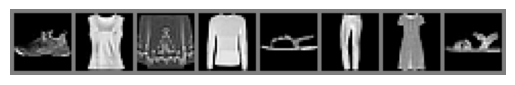

Labels: ['Sneaker', 'Shirt', 'Shirt', 'Pullover', 'Sandal', 'Trouser', 'Dress', 'Sandal']
FashionCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)
Epoch 1, Loss: 0.4070
Accuracy on test set: 88.55%


In [2]:
# ======================================
# FULL Fashion-MNIST CNN — ONE CELL FOR COLAB
# ======================================

# 1️⃣ Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# 2️⃣ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 3️⃣ Transforms & Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Fashion-MNIST is grayscale
])

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# 4️⃣ Tiny DataLoader for fast run (CPU-safe)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

classes = train_dataset.classes
print("Classes:", classes)

# 5️⃣ Show a few images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    if npimg.shape[0] == 1:  # grayscale
        plt.imshow(npimg.squeeze(), cmap='gray')
    else:  # RGB
        plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')
    plt.show()


images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[:8]))
print("Labels:", [classes[l] for l in labels[:8]])

# 6️⃣ Define simple CNN
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)   # 1 channel for grayscale
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.fc1   = nn.Linear(32*7*7, 128)           # 28x28 -> conv+pool twice -> 7x7
        self.fc2   = nn.Linear(128, 10)
        self.relu  = nn.ReLU()
    def forward(self,x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32*7*7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = FashionCNN().to(device)
print(model)

# 7️⃣ Training loop (1 epoch for demo)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1):  # 1 epoch demo
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# 8️⃣ Evaluate on test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100*correct/total:.2f}%")
